
# Assignment Module 2: Quantum‑Kernel SVM (QSVM)

This assignment focuses on **quantum‑kernel SVM (QSVM)** using a *Pennylane* implementation of the **inverse‑circuit overlap test**.

To complete the assignment, you will implement missing code (marked **YOUR CODE HERE**) and answer a set of short theoretical questions.

## Preparation

* Look at the [notebook](https://canvas.kth.se/courses/57561/files/9801323?module_item_id=1339648) on Quantum SVM.

## Use of generative AI tools

You may use AI-based tools (e.g., ChatGPT, GitHub Copilot, Claude, Gemini, DeepSeek, ...) for brainstorming, refactoring, coding assistance, plotting, or editing.

This is allowed with disclosure. LLMs are a great tool, but you have to make sure to grasp the contents of the course!

**Make sure to fill in the mandatory AI-disclosure in the notebook before submitting!**

## Preparatory code

Run this to import the modules we need

In [1]:
!pip install pennylane
!pip install jax~=0.6.0 jaxlib~=0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 132.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 201.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 216.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 145.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 MB 91.3 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.7.1
    Uninstalling jaxlib-0.7.1:
      Successfully uninstalled jaxlib-0.7.1
  Attempting uninstall: jax
    Found existing installation: jax 0.7.1
    Uninstalling jax-0.7.1:
      Successfully uninstalled jax-0.7.1

[notice] A new release of pip is available: 24

In [2]:
# Reproducibility
SEED = 123

# Imports
import math, sys, os, json, pathlib
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC

import pennylane as qml
from pennylane import numpy as pnp  # optional

print("pennylane versino: ", qml.__version__)

print("Imports OK")

/usr/local/lib/python3.12/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.1 is installed, but it is not compatible with the installed jaxlib version 0.6.2, so it will not be used.
  warnings.warn(


pennylane versino:  0.43.1
Imports OK


# Task 0: Loading the dataset

In this exercise, we will use the breast cancer dataset. Before designing the QSVM, we must first load the dataset, and split the datapoints into a training and test set. Furthermore, we will apply a scaling to the input features using the `StandardScaler()`, which ensures that the features have zero mean and unity variance. Remember to fit the scaler on the training data, and using the same fitted scaler on both the training and test datasets!

In [3]:
# Data loading and preprocessing
# TODO: Load Breast Cancer dataset, map labels to {-1,+1}, train/test split, and scale features.

data = load_breast_cancer()
# -----YOUR CODE HERE-----
# Load dataset
X = data['data']
y01 = data['target']

# Remap binary labels from 0/1 to -1/+1
y = np.where(y01==1, +1, -1)

# Split in train and test datasets
X_tr, X_te, y_tr, y_te = train_test_split(X, y)

# Make mean 0 and standard diviation 1
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)
# ---YOUR CODE ENDS HERE---

print("Shapes:", X_tr.shape, X_te.shape, " (+1 count):", (y_tr==+1).sum(), " (-1 count):", (y_tr==-1).sum())

Shapes: (426, 30) (143, 30)  (+1 count): 275  (-1 count): 151


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 0.1 — Short answer
Why is feature scaling important for angle‑embedding feature maps? Write a concise justification (2–4 sentences).
</div>

**Answer**: To avoid issues with wrap-around, that is when the angle is greater than or equal to $2\pi$ and we run into issues with aliasing of embeddings. But if the range is too narrow instead, we lose expressivity of the embeddings.


# Task 1: Dimensionality reduction using PCA
For angle‑based maps we set the number of qubits equal to the feature dimension. Unfortunately, the available qubit count is often smaller than the dimensionality of the data. Here, we use PCA to reduce the data dimensionality to `n_qubits` components. Remember to fit the PCA transform on the training data, and using the same fitted scaler on both the training and test datasets!

**Instructions:**
1. Choose `n_qubits` (e.g., 8).
2. Fit `PCA(n_components=n_qubits)` on the training data and transform train/test.
3. Print shapes to confirm.


In [4]:
# PCA reduction to match qubits
# -----YOUR CODE HERE-----
n_qubits = 8
pca = PCA(n_components=n_qubits)
Xtr_red = pca.fit_transform(X_tr)
Xte_red = pca.transform(X_te)
# ---YOUR CODE ENDS HERE---
print("Reduced shapes:", Xtr_red.shape, Xte_red.shape)

Reduced shapes: (426, 8) (143, 8)


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 1.1 — Short answer
What are the trade‑offs in choosing a small vs a large `n_qubits` for angle‑embedding maps (consider noise/depth, and dataset size,...)?
</div>

**Answer**: With more qubits we get more expressivity but we are also more exposed to noise as we can have bigger, more complicated circuits. Also stated on the first lecture, deep circuits are hard to implement on real quantum computers due the coherence time being short. Additionally, more qubits means a higher requirement on memory and processing, which might not work depending on hardware constraints.

# Task 2: Implement an angle‑embedding feature map
Implement a simple angle‑embedding feature map followed by a ring of $CZ$ entanglers.

**Instructions:**
1. Define a device `default.qubit` with `n_qubits` wires and analytic mode (`shots=None`).
2. Implement `feature_map_angle(x, scale=1.0, entangle=True)` that applies `AngleEmbedding(..., rotation="Y")` and a CZ ring when `entangle=True`.
3. Do **not** return anything; this is a template used inside a QNode.

In [5]:
# Device and feature map

dev = qml.device("default.qubit", wires=n_qubits, shots=None, seed=SEED)

# @qml.qnode(dev)
def feature_map_angle(x, wires=None, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    qml.AngleEmbedding(x*scale, wires=wires, rotation="Y")
    if entangle:
        for i in range(len(wires)-1):
            qml.CZ(wires[i:i+1+1])
        qml.CZ([wires[-1], wires[0]])
    # ---YOUR CODE ENDS HERE---
    return None

# print(qml.draw(feature_map_angle)(Xtr_red[5], wires=[0,1,2,3,4,5,6,7]))

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 2.1: Short answer
Explain (2–4 sentences) how the entangling layer can change the induced kernel compared to a no‑entanglement feature map.
</div>

**Answer**: If we don't have entanglement the probability of measuring the qubits will be independent given the features (as there are no entanglement connection), so this is might aswell be implemented on a classical computer. When we entangle the states our quantum kernel can be much more expressive, and have more complicated dependencies. As an example, with a ZZ gate we can encode pairwise structure into the feature map and thus the kernel.

# Task 3: Inverse‑circuit (overlap) kernel QNode

We estimate $k(x,z) = |\langle \phi(z) | \phi(x) \rangle|^2$ by the inverse‑circuit method.

**Instructions:**
Implement the function `all_probabilities(x, z, scale=1.0, entangle=True)` as a QNode that
   1. Encodes `x` with `feature_map_angle`
   2. Applies the adjoint encoding of `z`,
   3. Returns the output probabilities corresponding to all possible bitstring outcomes using `qml.probs()`.

The kernel $k(x,z)$ equals the probability of measuring zero on all qubits, which we denote as $\Pr(0^n)$. We must therefore extract the probability of this specific outcome. We provide a helper function `overlap_probability()` that extracts $\Pr(0^n)$.

Call `overlap_probability()` on a small subset of your training data points to confirm outputs lie in the range $[0,1]$!


In [6]:
# TODO: QNode returning Pr(0^n)
@qml.qnode(dev)
def all_bitstring_probabilities(x, z, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    feature_map_angle(x, wires=list(range(len(x))), scale = scale, entangle=entangle)
    qml.adjoint(feature_map_angle)(z, wires=list(range(len(z))), scale=scale, entangle=entangle)
    probs = qml.probs()
    # ---YOUR CODE ENDS HERE---
    return probs

def overlap_probability(x, z, scale=1.0, entangle=True):
    return all_bitstring_probabilities(x, z, scale=scale, entangle=entangle)[0]

# Quick sanity check for x_5
print("Overlap:", overlap_probability(Xtr_red[5], Xtr_red[5]))
# print(qml.draw(all_bitstring_probabilities)(Xtr_red[5], Xtr_red[5]))

Overlap: 0.9999999999999998


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 3.1 — Derivation
Show that $\Pr(0^n)$ equals the fidelity kernel value $k(x,z)=|\langle \phi(z) | \phi(x) \rangle|$, where $\Pr(0^n)$ denotes the probability of measuring 0 on all qubits in the circuit above. Provide a short derivation using Dirac notation (2–8 lines).
</div>

**Answer**: We have
$$
\ket{\phi(x)} = U_{\phi}(x)\ket{0^n} \implies \bra{\phi(z)} = (U_{\phi}(z)\ket{0^n})^\dagger = \bra{0^n}U_{\phi}^\dagger(z)
$$

<!-- Therefore if we prepare $\ket{0^n}$, apply $U_{\phi}(x)$, then apply $U^{\dagger}_{\phi}(z)$ the amplitude of the all-zeros basis state equals the desired inner product. The measurement probability of $0^n$ equals its squared magnitude: -->

After applying the quantum circuit $U^{\dagger}_{\phi}(z) U_{\phi}(x)$ on $\ket{0^n}$ we can measure the probability of $\ket{0^n}$ by projecting using $\bra{0^n}$ and taking the squared norm. Thus

$$
Pr(0^n) = |\bra{0^n} U^{\dagger}_{\phi}(z) U_{\phi}(x)\ket{0^n}|^2 = |\braket{\phi(z)|\phi(x)}|^2 = k(x,z)
$$

Note that since $U_\phi$ is unitary, the probability mass across all states is preserved by $U^{\dagger}_{\phi}(z) U_{\phi}(x)$.


# Task 4: Build a Gram matrix

Implement `quantum_kernel(A, B, ...)` that returns a matrix $K$ with entries $K_{ij}=k(A_i,B_j)$.

**Instructions:**
1. Loop over rows of `A` and `B` and call `overlap_probability` in order to construct the Gram matrix.
2. Time your function on a small subset (e.g., 40×40) and comment on the $(O(n^2)$ cost.

In [7]:
# Gram matrix builder
def quantum_kernel(A, B, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    K = np.array([[overlap_probability(a,b, scale=scale) for b in B] for a in A])
    
    # ---YOUR CODE ENDS HERE---
    return K


# mini benchmark
Amini = Xtr_red[:40]; Bmini = Xtr_red[:40]
Kmini = quantum_kernel(Amini, Bmini)
print("Kmini shape:", Kmini.shape, "  min/max:", Kmini.min(), Kmini.max())

Kmini shape: (40, 40)   min/max: 8.255183615837602e-12 1.0000000000000009


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 4.1: Symmetry and jitter
Why do we not need to symmetrize and add jitter now that we run on a simulator?
</div>

**Answer**: Since we have no true noise and exact probabilities calculated classically, which we would not get using a quantum computer. The simulated device is running with shots=None, and so we do not get the noise that normally can cause tiny negative eigenvalues (non-PSD behaviour).

# Task 5: Train a QSVM with a precomputed kernel

Train an SVM on the **precomputed** Gram matrix.

**Instructions.**
1. Compute the Gram matrix of `Xtr_red` and `Xtr_red`.
2. Fit `SVC(kernel="precomputed", C=...)` on `(K_tr, y_tr)`.
3. Compute the Gram matrix of the `Xtr_red` and `Xtr_red`. Predict on test data, report accuracy and confusion matrix.
4. Briefly comment on your results (1–3 sentences).


In [8]:
# -----YOUR CODE HERE-----
# Create the Gram matrix for the training data.
# Note that this might take around 20-40 min to run.
K_tr = quantum_kernel(Xtr_red, Xtr_red)
# ---YOUR CODE ENDS HERE---

# We save the matrix for further use
np.savetxt("K_tr.mpy", K_tr)


Use the Gram matrix to train the data.

In [9]:
K_tr = np.loadtxt("K_tr.mpy")

C = 1.05  # Hyper parameter you may tune
clf = SVC(kernel="precomputed", C=C)

# -----YOUR CODE HERE-----
# Fit the classifier to the training data
SVM = clf.fit(K_tr.T, y_tr.T)
# ---YOUR CODE ENDS HERE---


Compute the Gram matrix for all pairs of training and test data.

In [10]:
# -----YOUR CODE HERE-----
# X_concat = np.concatenate((Xtr_red, Xte_red))
K_te_tr = quantum_kernel(Xte_red, Xtr_red)
# ---YOUR CODE ENDS HERE---
np.savetxt("K_te_tr.mpy", K_te_tr)

Use the classifier and the Gram matrix of the training and test data to predict labels for the test data.

QSVM test accuracy: 0.7972


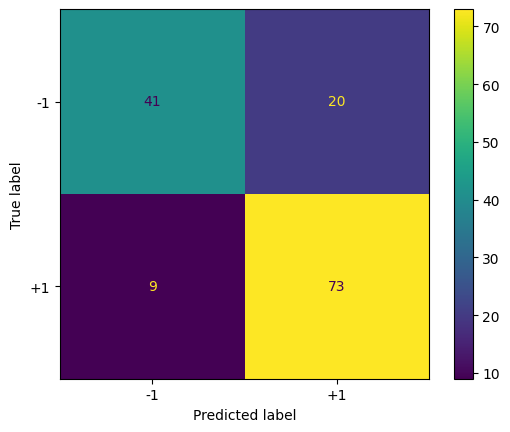

              precision    recall  f1-score   support

     neg(-1)       0.82      0.67      0.74        61
     pos(+1)       0.78      0.89      0.83        82

    accuracy                           0.80       143
   macro avg       0.80      0.78      0.79       143
weighted avg       0.80      0.80      0.79       143



In [11]:
K_te_tr = np.loadtxt("K_te_tr.mpy")

# -----YOUR CODE HERE-----
y_pred = SVM.predict(K_te_tr)
acc = accuracy_score(y_pred, y_te)
# ---YOUR CODE ENDS HERE---

print(f"QSVM test accuracy: {acc:.4f}")
cm = confusion_matrix(y_te, y_pred, labels=[-1,+1])
ConfusionMatrixDisplay(cm, display_labels=["-1","+1"]).plot(values_format="d"); plt.show()
print(classification_report(y_te, y_pred, target_names=["neg(-1)","pos(+1)"]))

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 5.1: Short answer
Where do labels $(\pm 1)$ enter the SVM training when using a precomputed kernel? Answer in 2–4 sentences.

</div>

**Answer**: When we give sklearn the precomputed kernel, it solves the dual problem which reads:

$$
\max_a \quad \sum_j \alpha_j - \frac{1}{2}\sum_{i,j} y_iy_j \alpha_i\alpha_j K_{i,j}
$$
$$
\textrm{subject to} \quad 0\leq \alpha_j \leq C, \quad \quad \quad \quad \quad \quad \quad
$$
$$
 \sum_j \alpha_j y_j = 0 \quad \quad
$$


Where the $y_i$ are the labels.


## Task 6: Classical baseline (RBF SVM)
The code below trains a conventional SVM with an RBF kernel on the same PCA‑reduced features. Compare accuracy and qualitative behavior.


RBF SVM accuracy: 0.986013986013986


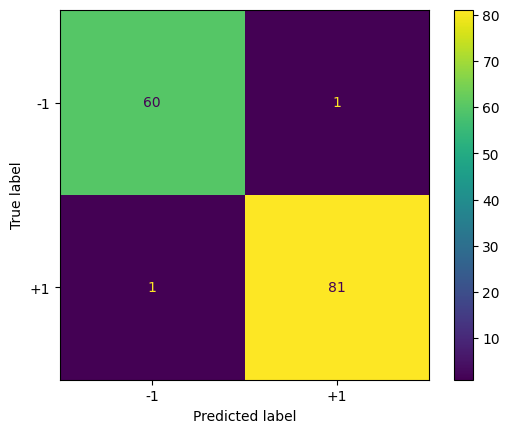

In [12]:
rbf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=SEED)
rbf.fit(Xtr_red, y_tr)
rbf_pred = rbf.predict(Xte_red)
print("RBF SVM accuracy:", accuracy_score(y_te, rbf_pred))
cm = confusion_matrix(y_te, rbf_pred, labels=[-1,+1])
ConfusionMatrixDisplay(cm, display_labels=["-1","+1"]).plot(values_format="d"); plt.show()

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 6.1: Short answer
How does the result differ between the QSVM and the classical SVM? Answer in 2–4 sentences.
</div>

**Answer**: The QSVM performs quite a bit worse. With about 79.0% accuracy vs about 98.6%. This suggests that our feature map may not be a good fit for this task, or at least worse than the RBF kernel. This could possibly be remedied by a better feature map.



# Bonus A: Gram‑matrix spectral analysis
Perform a basic spectral analysis to diagnose kernel quality and potential concentration.

**Instructions:**
1. Compute eigenvalues of $K$ (and of the centered kernel $K_c = H K H$ with $H=I-\frac{1}{n}\mathbf{1}\mathbf{1}^\top$).
2. Plot scree diagrams (eigenvalues in descending order).
3. Compute effective rank $r_\mathrm{eff} = (\sum \lambda_i)^2 / \sum \lambda_i^2$.
4. Plot histograms of same‑class vs different‑class similarities.


[Test]  n=426
  Sum eigs: 426.0000  |  r_eff: 96.69
  Sum eigs (centered): 410.2207  |  r_eff (centered): 118.86
  Top-5 eigs: [25.340127 13.339327 10.348935  9.948441  9.043417]


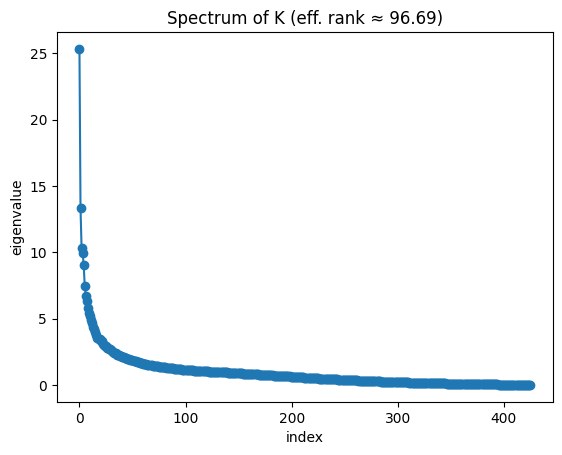

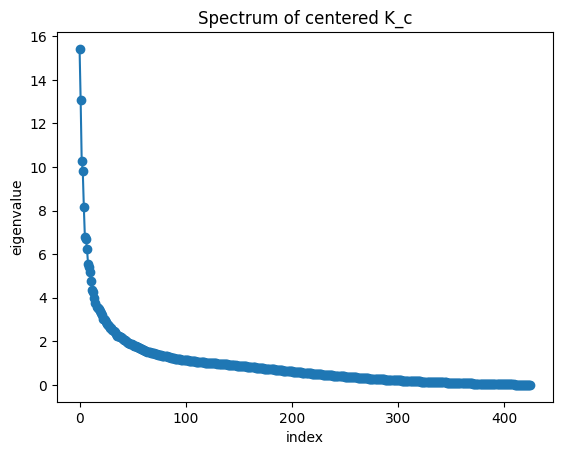

In [13]:
# Spectral analysis of K
# -----YOUR CODE HERE-----

# Code adapted from "QSVM_Spectral_Analysis_DD2368 (2)" notebook provided in the course

def symmetrize(K):
    return 0.5 * (K + K.T)

def center_kernel(K):
    n = K.shape[0]
    H = np.eye(n) - np.ones((n,n))/n
    return H @ K @ H

def spectrum(Kc):
    # Kc should be symmetric; eigh returns sorted ascending → flip
    # Note that we symmetrize again for precaution (rounding error might introduce asymm.)
    w, _ = np.linalg.eigh((Kc + Kc.T) * 0.5)
    w = w[::-1]
    return w

def effective_rank(eigs, clip_at=0.0):
    # Clip tiny negatives from numerical issues before r_eff
    lam = np.copy(eigs)
    lam[lam < clip_at] = 0.0
    s1 = lam.sum()
    s2 = (lam**2).sum()
    return (s1**2 / s2) if s2 > 0 else 0.0


K = K_tr
y = y_tr


# 1) Symmetrize
K_sym = symmetrize(K)
# 2) Center
Kc = center_kernel(K_sym)
# 3) Spectrum
eigs = spectrum(K_sym)
# We use symmetrized K to compensate for issues with numerical precision, 
# not because of noise (since we have none)
eff_rank = effective_rank(eigs, clip_at=0.0)
eigs_c = spectrum(Kc)

print(f"[Test]  n={K.shape[0]}")
print(f"  Sum eigs: {eigs.sum():.4f}  |  r_eff: {eff_rank:.2f}")
eff_rank_c = effective_rank(eigs_c, clip_at=0.0)
print(f"  Sum eigs (centered): {eigs_c.sum():.4f}  |  r_eff (centered): {eff_rank_c:.2f}")
print(f"  Top-5 eigs: {np.round(eigs[:5], 6)}")



# ---YOUR CODE ENDS HERE---

plt.figure(); plt.plot(eigs, marker='o'); plt.title(f"Spectrum of K (eff. rank ≈ {eff_rank:.2f})")
plt.xlabel("index"); plt.ylabel("eigenvalue"); plt.show()

plt.figure(); plt.plot(eigs_c, marker='o'); plt.title("Spectrum of centered K_c")
plt.xlabel("index"); plt.ylabel("eigenvalue"); plt.show()



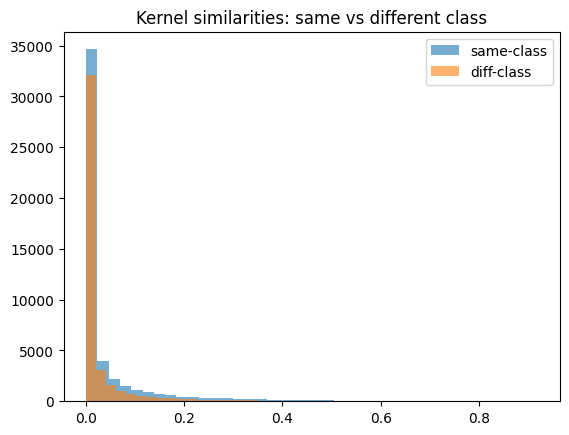

Top-5 eigenvalues: [25.34012681 13.33932695 10.34893475  9.94844135  9.04341669]


In [14]:
# -----YOUR CODE HERE-----
# Similarity histogram: same vs diff classes

# Code adapted from "QSVM_Spectral_Analysis_DD2368 (2)" notebook provided in the course

n = K.shape[0]
same, diff = [], []
for i in range(n):
    for j in range(i+1, n):
        if y[i] == y[j]:
            same.append(K_sym[i,j])
        else:
            diff.append(K_sym[i,j])
# ---YOUR CODE ENDS HERE---

plt.figure()
plt.hist(same, bins=40, alpha=0.6, density=False, label="same-class")
plt.hist(diff, bins=40, alpha=0.6, density=False, label="diff-class")
plt.title("Kernel similarities: same vs different class"); plt.legend(); plt.show()

print("Top-5 eigenvalues:", eigs[:5])

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question Bonus A.1: Interpretation
Comment on the spectra you obtained. Do you see signs of kernel concentration (near‑identity or rank‑1 structure)? How does the centered spectrum differ?

</div>


**Answer**: We get an effective rank for the non-centered kernel of ~96.7 out of 426, meaning it is not great, but we still have a few non-small eigenvalues as can be seen in the scree plot. The scree plot for the non-centered looks similar to, albeit a bit worse than its centered counterpart. Looking at the centered kernel, we have an effective rank of ~118.9 , and in the scree plot we see that we have a few dominant eigenvalues which is not optimal (and many are below 1 after about the 100 largest eigenvalues). Furthermore, the within class vs between class similarities histograms are also bad, even though they do reflect some differentiation, the plots suggest that the kernel has a hard time to tell the difference between samples within and between class.



# Bonus B: Feature-map variations
Evaluate the impact of modifying the feature map (e.g., adding depth or changing rotation axis).

**Instructions:**
1. Implement an alternative map (e.g., two angle+CZ layers or `rotation="X"`).
2. Rebuild $K_{tr}$, $K_{te}$, retrain the SVM, and report test accuracy.
3. Compare spectra as in Bonus A. Summarize observations (3-6 sentences).


In [15]:
@qml.qnode(dev)
def feature_map_angle_B(x, wires=None, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    qml.AngleEmbedding(x, wires=wires, rotation="Y")
    if entangle:
        for i in range(len(wires)-1):
            qml.CZ(wires[i:i+1+1])
        qml.CZ([wires[-1], wires[0]])
    qml.AngleEmbedding(x, wires=wires, rotation="Y")
    if entangle:
        for i in range(len(wires)-1):
            qml.CZ(wires[i:i+1+1])
        qml.CNOT([wires[-1], wires[0]])
    # ---YOUR CODE ENDS HERE---
    return None
print(qml.draw(feature_map_B)(Xtr_red[5], [0,1,2,3,4,5,6,7]))

NameError: name 'feature_map_B' is not defined

In [16]:
# Alternative feature map (example: deeper Y-embedding with two layers)
# -----YOUR CODE HERE-----

def feature_map_angle_B(x, wires=None, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    # qml.AngleEmbedding(x, wires=wires, rotation="Y")
    qml.AngleEmbedding(x, wires=wires, rotation="X")
    if entangle:
        for i in range(len(wires)-1):
            qml.CZ(wires[i:i+1+1])
        qml.CZ([wires[-1], wires[0]])
    # qml.AngleEmbedding(x, wires=wires, rotation="Y")
    # if entangle:
    #     for i in range(len(wires)-1):
    #         qml.CZ(wires[i:i+1+1])
    #     qml.CNOT([wires[-1], wires[0]])
    # ---YOUR CODE ENDS HERE---
    return None

@qml.qnode(dev)
def all_bitstring_probabilities_B(x, z, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    feature_map_angle_B(x, wires=list(range(len(x))), scale = scale, entangle=entangle)
    qml.adjoint(feature_map_angle_B)(z, wires=list(range(len(z))), scale=scale, entangle=entangle)
    probs = qml.probs()
    # ---YOUR CODE ENDS HERE---
    return probs

def overlap_probability_B(x, z, scale=1.0, entangle=True):
    return all_bitstring_probabilities_B(x, z, scale=scale, entangle=entangle)[0]
    
def quantum_kernel_B(A, B, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    K = np.array([[overlap_probability_B(a,b) for b in B] for a in A])
    
    # ---YOUR CODE ENDS HERE---
    return K
    
K_tr_B = quantum_kernel_B(Xtr_red, Xtr_red)

np.savetxt("K_tr_B.mpy", K_tr_B)


K_te_tr_B = quantum_kernel_B(Xte_red, Xtr_red)


QSVM test accuracy: 0.7902


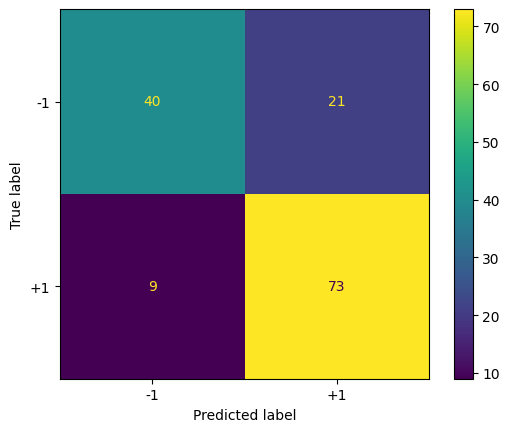

              precision    recall  f1-score   support

     neg(-1)       0.82      0.66      0.73        61
     pos(+1)       0.78      0.89      0.83        82

    accuracy                           0.79       143
   macro avg       0.80      0.77      0.78       143
weighted avg       0.79      0.79      0.79       143



In [17]:
np.savetxt("K_tr_B.mpy", K_te_tr_B)

C = 1.0  # Hyper parameter you may tune
clf = SVC(kernel="precomputed", C=C)

# -----YOUR CODE HERE-----
# Fit the classifier to the training data
SVM = clf.fit(K_tr_B.T, y_tr.T)
# ---YOUR CODE ENDS HERE---

# -----YOUR CODE HERE-----
y_pred = SVM.predict(K_te_tr_B)
acc = accuracy_score(y_pred, y_te)
# ---YOUR CODE ENDS HERE---

print(f"QSVM test accuracy: {acc:.4f}")
cm = confusion_matrix(y_te, y_pred, labels=[-1,+1])
ConfusionMatrixDisplay(cm, display_labels=["-1","+1"]).plot(values_format="d"); plt.show()
print(classification_report(y_te, y_pred, target_names=["neg(-1)","pos(+1)"]))

[Test]  n=426
  Sum eigs: 426.0000  |  r_eff: 96.69
  Sum eigs (centered): 410.2207  |  r_eff (centered): 118.86
  Top-5 eigs: [25.340127 13.339327 10.348935  9.948441  9.043417]


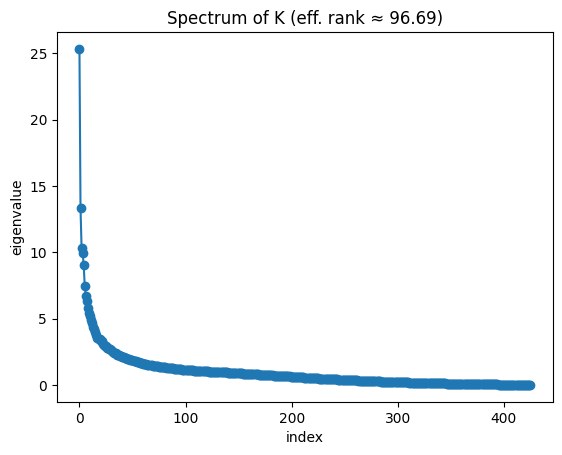

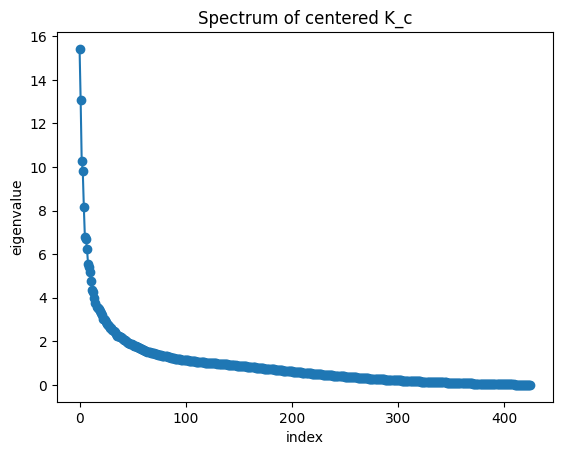

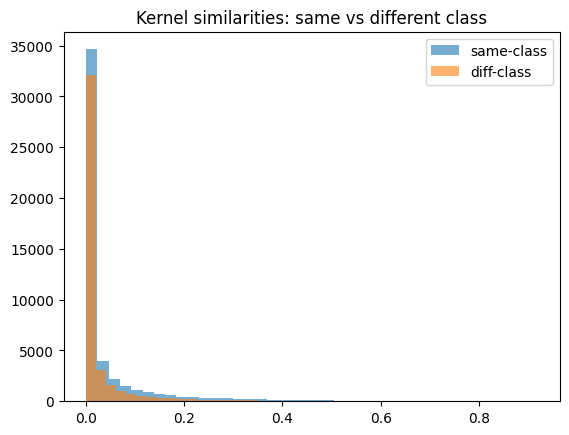

Top-5 eigenvalues: [25.34012681 13.33932695 10.34893475  9.94844135  9.04341669]


In [18]:
K = K_tr
y = y_tr



K_sym = symmetrize(K)
Kc = center_kernel(K_sym)
eigs = spectrum(K_sym)
# We use symmetrized K to compensate for issues with numerical precision, 
# not because of noise (since we have none)
eff_rank = effective_rank(eigs, clip_at=0.0)
eigs_c = spectrum(Kc)

print(f"[Test]  n={K.shape[0]}")
print(f"  Sum eigs: {eigs.sum():.4f}  |  r_eff: {eff_rank:.2f}")
eff_rank_c = effective_rank(eigs_c, clip_at=0.0)
print(f"  Sum eigs (centered): {eigs_c.sum():.4f}  |  r_eff (centered): {eff_rank_c:.2f}")
print(f"  Top-5 eigs: {np.round(eigs[:5], 6)}")



# ---YOUR CODE ENDS HERE---

plt.figure(); plt.plot(eigs, marker='o'); plt.title(f"Spectrum of K (eff. rank ≈ {eff_rank:.2f})")
plt.xlabel("index"); plt.ylabel("eigenvalue"); plt.show()

plt.figure(); plt.plot(eigs_c, marker='o', ); plt.title("Spectrum of centered K_c")
plt.xlabel("index"); plt.ylabel("eigenvalue"); plt.show()

n = K.shape[0]
same, diff = [], []
for i in range(n):
    for j in range(i+1, n):
        if y[i] == y[j]:
            same.append(K_sym[i,j])
        else:
            diff.append(K_sym[i,j])


plt.figure()
plt.hist(same, bins=40, alpha=0.6, density=False, label="same-class")
plt.hist(diff, bins=40, alpha=0.6, density=False, label="diff-class")
plt.title("Kernel similarities: same vs different class"); plt.legend(); plt.show()

print("Top-5 eigenvalues:", eigs[:5])

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question Bonus B.1: Wrap‑up discussion
Write 1–2 short paragraphs summarizing your results: performance, any signs of concentration, and whether feature‑map changes improved or degraded the kernel and accuracy.

</div>


**Answer**: The scree plots does not look too good, but it does not look that bad, we still have a few dominant eigenvalues (not just one). Moreover, the within vs between class histograms shows that the induced kernel from the (non-bonus task and the bonus-task) feature map has a hard time to tell the differenece between inclass and between class, becasue we see alot of concetration around 0 for the between class kernel values. Moreover, when we tried to improve the feature map by adding another layer, we did not notice any increase in performance and saw similar results, unfortunately. This shows that it is hard is sometimes hard to choose a good feature map. The performance with the bonus-task feature map is 0.79 \% accuracy and with the non-bonus task feature map it is also 0.79 \%.

# Feedback to us

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Optional question
Was there any part of the tasks where you struggled for some "unnecessary" reason? (Errors in the notebook, bad instructions etc.)

</div>

**Answer**: [Your optional answer here]

# Disclosure of AI Usage (Mandatory)
Fill in this part disclosing any AI usage before submitting the assignment by describing your use of LLMs or other AI-based tools in this assignment.

For each task, we ask you to provide information about:
- **Tools/models used**.
- **Per‑task usage**: for each task, a brief summary of what the tool was used for.
- **Prompts/transcripts**: main prompts or a summary of interactions (a link or screenshot is acceptable if long).
- **Validation**: how you checked and verified the correctness of AI-generated outputs (tests run, docs consulted, comparisons, plots etc.).

Disclosure:
- **Task 0**: None

- **Task 1**: Pasted a screenshot of slide 6 from the QML_QuantumFeatureMaps_InPerson.pdf (which contained bullet points on Encoding choices, Structural choices, Connectivity patterns, Trade-offs) and asked GPT-5 to talk more about these points. It mentioned the problem of coherence time for deeper networks, I verified this by recalling that we have also talked about this during lecture.

- **Task 2**: Asked GPT-5 to clarify what a CZ "ring" might mean while waiting for an answer from Stefano. In the end we followed the answer we got in the email.

- **Task 3**: None

- **Task 4**: None

- **Task 5**: None

- **Task 6**: None

- **Bonus A**: None

- **Bonus B**: None

If you did not use any AI tools for a given exercise, specify this by writing "None". If you did not complete the bonus exercises, you can leave those fields empty.